<a href="https://colab.research.google.com/github/monci-mamachan628/HOMEWORK2/blob/main/LOAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

You work for a company that provides car loans with interest rates. Recently, loan underwriters have been issuing a significant number of loans that end up defaulting. As a result, there’s a need to improve the underwriting process. To address this issue, you decide to use a random forest algorithm to enhance the accuracy and reliability of loan approvals.

# Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings

# Suppress warnings:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')



predict the probability of a customer defaulting on a loan. The target variable is "default payment." Details of the data measurements can be found in UCI's data repository.

In [ ]:
# Import the data set
df = pd.read_excel('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UEym8G6lwphKjuhkLgkXAg/default%20of%20credit%20card%20clients.xls', header=1)

Exploring the data set is a critical step that should not be overlooked. This can help you to understand what data is available and the quality of that data. This guides both data cleaning and modeling decisions. First, let's look at the first five rows of the DataFrame.

In [ ]:
# Explore the first five rows of the data set
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Each row represents an individual. Some columns that could be useful are:

Credit limit (LIMIT_BAL)
Prior payment status (PAY_0,...,PAY_6)
Bill and payment amounts (BILL_AMT, PAY_AMT)
Target variable that indicates default next month (default payment next month)
The following code renames the default column. The ID column is also dropped because it doesn't contain any information relevant to the analysis.

In [ ]:
# Rename the columns
df.rename({'default payment next month': 'DEFAULT'}, axis='columns', inplace=True)

#Remove the ID column as it is not informative
df.drop('ID', axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Analysing the missing data

One key step is to check for null values or other invalid input that will cause the model to throw an error.

In [ ]:
#checking dimension for invalid values
print(f"sex value include : {df['SEX'].unique()}")
print(f"EDUCATION value include : {df['EDUCATION'].unique()}")
print(f"MARRIAGE value include : {df['MARRIAGE'].unique()}")
#counting missing or null values
print(f"missing value in SEX : {len(df[pd.isnull(df['SEX'])])}")
print(f"missing value in EDUCATION : {len(df[pd.isnull(df['EDUCATION'])])}")
print(f"missing value in MARRIAGE : {len(df[pd.isnull(df['MARRIAGE'])])}")
print(f"missing value in AGE : {len(df[pd.isnull(df['AGE'])])}")

#COUNT OF INVALID DATA DATA IN EDUCATION AND MARRIAGE
invalid_count = len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])
print(f"Number of invalid data points in EDUCATION or MARRIAGE: {invalid_count}")


sex value include : [2 1]
EDUCATION value include : [2 1 3 5 4 6 0]
MARRIAGE value include : [1 2 3 0]
missing value in SEX : 0
missing value in EDUCATION : 0
missing value in MARRIAGE : 0
missing value in AGE : 0
Number of invalid data points in EDUCATION or MARRIAGE: 68
Number of invalid data points in EDUCATION or MARRIAGE: 68


let's filter the rows where the EDUCATION and MARRIAGE columns have non-zero values.

The following code creates a new DataFrame with the missing values for EDUCATION and MARRIAGE removed. We end up with 29,932 rows remaining.

In [ ]:
print(f"shape of data: {df.shape}")
#Filter the DataFrame
df_no_missing_data = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
print(f"shape of no_missing_data: {df_no_missing_data.shape}")

shape of data: (30000, 24)
shape of no_missing_data: (29932, 24)


The next step is to check if the target variable, which indicates whether someone defaulted, is balanced. The chart shows counts of people who have defaulted (1) and haven't defaulted (0). Unsurprisingly, most people have not defaulted on their loans.

To address this class imbalance, you must down sample the data.

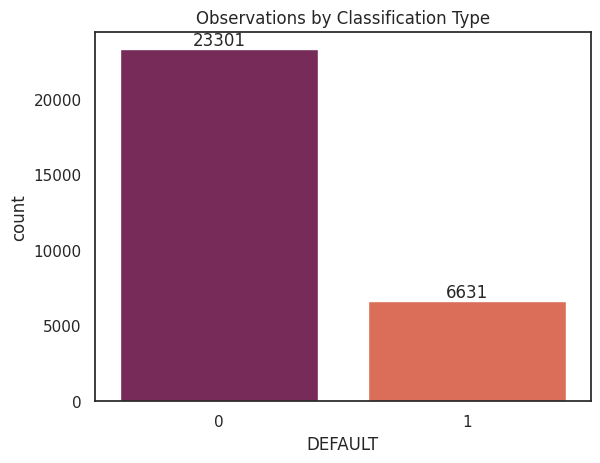

In [ ]:
# Explore distribution of data set
# count plot on ouput variable
ax = sns.countplot(x = df_no_missing_data['DEFAULT'], palette = 'rocket')

#add data labels
# ax.bar_label(ax.containers[0])
for container in ax.containers:
    ax.bar_label(container)

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

# Downsample the data set

The first step in downsampling is to split the data based on those who defaulted on their loan and those who did not default on their loan.

You will randomly select 1,000 samples from each category.

The two data sets are then merged back together to create an analysis data set.

In [ ]:
# split data
df_no_default = df_no_missing_data.loc[(df_no_missing_data['DEFAULT']==0)]
df_default = df_no_missing_data.loc[(df_no_missing_data['DEFAULT']==1)]

# downsample the data set
df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=1000, random_state=0)
df_default_downsampled = resample(df_default, replace=False, n_samples=1000, random_state=0)

#check ouput
print(f"Length of df_no_default_downsampled: {len(df_no_default_downsampled)}")
print(f"Length of df_default_downsampled: {len(df_default_downsampled)}")

# merge the data sets
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled ])
print(f"Shape of df_downsample: {df_downsample.shape}")

Length of df_no_default_downsampled: 1000
Length of df_default_downsampled: 1000
Shape of df_downsample: (2000, 24)


# Hot encode the independent variables

Next, we convert each category into a binary variable with a value of 0 or 1. Pandas has a very convenient function to do just this, called get_dummies.

In [ ]:
# isolate independent variables
X = df_downsample.drop(['DEFAULT','SEX', 'EDUCATION', 'MARRIAGE','AGE'], axis=1).copy()
print(f"Shape of X: {X.shape}")

# NOTE: 'PAY_1' is not shown in original data
X_encoded = pd.get_dummies(data=X, columns=['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
print(f"Shape of X_encoded: {X_encoded.shape}")
X_encoded.head()

Shape of X: (2000, 19)
Shape of X_encoded: (2000, 70)


,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
2320,50000,390,918,19583,19593,19364,19893,918,19583,1000,...,False,False,False,True,False,False,False,False,False,False
2887,500000,24170,8051,77908,50297,43679,49749,8091,78192,65,...,False,False,False,True,False,False,False,False,False,False
9916,220000,4289,4637,1252,8069,18117,23176,1031,3077,7500,...,False,False,False,True,False,False,False,False,False,False
24070,80000,77901,79605,79207,0,0,0,3600,2407,0,...,False,True,False,False,False,False,False,False,False,False
16550,220000,38074,43083,47051,65321,83882,72812,6000,5000,20012,...,False,False,False,True,False,False,False,False,False,False


# Split the data set

Splitting the data into test and training sets is critical for understanding how the model performs on new data. The random forest model uses the training data set to learn what factors should become decision nodes. The test set helps you evaluate how often those decisions lead to the correct decision.

In [ ]:
# Split the data
y = df_downsample['DEFAULT'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=0)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (1400, 70)
X_test.shape: (600, 70)
y_train.shape: (1400,)
y_test.shape: (600,)


# Classify accounts and evaluate the model

Now, it's time to build an initial random forest model by fitting it by using the training data and evaluating the resulting model using the test data. To make that evaluation easier, you plot the results using a confusion matrix.

Accuracy: 63.83%
Percentage of correctly predicted Did Not Default: 66.88%
Percentage of correctly predicted Defaulted: 60.62%


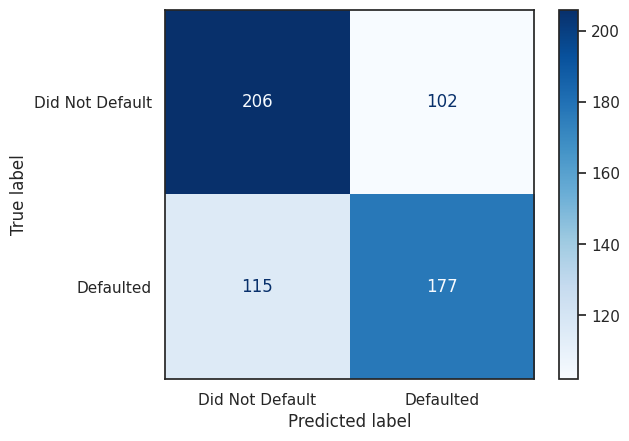

In [ ]:
# apply RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf.fit(X_train, y_train)

#calculate overall accuracy
y_pred = clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

class_names = ['Did Not Default', 'Defaulted']

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentage of correctly predicted instances for each class
for i, class_name in enumerate(class_names):
    correct_predictions = cm[i, i]
    total_predictions = cm[i, :].sum()
    class_accuracy = correct_predictions / total_predictions * 100
    print(f'Percentage of correctly predicted {class_name}: {class_accuracy:.2f}%')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

we can see, the model performance could be improved.

# Optimize the model with hyperparameter tuning

Cross validation and GridSearchCV are useful tools for finding better hyperparameters for models.
**max_depth**: The maximum number levels the decision trees that make up the random forest are allowed to have.

**min_samples_spli**t: The minimum number of samples that must be in a node for a decision split to be allowed.

**min_samples_leaf**: The minimum number of samples that must exist in a leaf node.

Another commonly used hyperparameter is **max_features**. This is the number of features that the model will try out when attempting to create a decision node. The **n_estimators** hyperparameter controls the number of decision trees that are created as part of the random forest model.

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4}
Best estimator is: RandomForestClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3,
                       random_state=0)
Accuracy: 67.00%


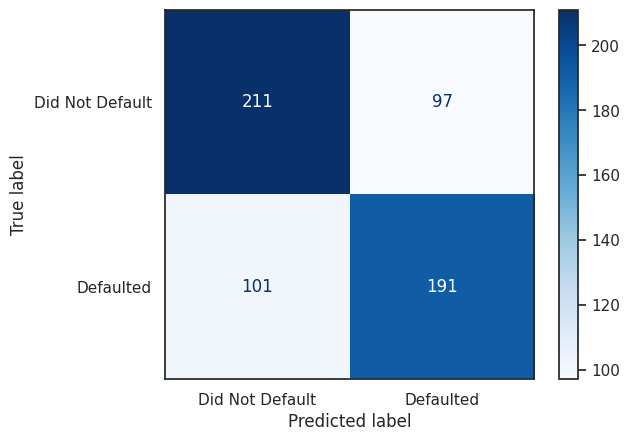

In [ ]:
param_grid = {
    'max_depth':[3,4,5],
    'min_samples_split':[3,4,5],
    'min_samples_leaf':[3,4,5],
}

rf_random = RandomizedSearchCV(
    estimator=clf_rf,
    param_distributions=param_grid,
    n_iter=27,
    cv=3,
    random_state=0,
    verbose=1,
    n_jobs = -1,
)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Output the best hyperparameters found
best_params = rf_random.best_params_
print(f'Best parameters found: {best_params}')
print(f'Best estimator is: {rf_random.best_estimator_}')

# Refit the model using the best hyperparameters
best_clf_rf = rf_random.best_estimator_

# In case you want to check all parameters currently in use
# print(f'Parameters currently in use: {best_clf_rf.get_params()}')

# Train the refitted model
best_clf_rf.fit(X_train, y_train)

# Calculate overall accuracy
y_pred = best_clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

# Plot the confusion matrix
class_names = ['Did Not Default', 'Defaulted']
disp = ConfusionMatrixDisplay.from_estimator(
    best_clf_rf,
    X_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.show()